# TP 5 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [149]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *

In [150]:
from functions import *

In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Restauracion de Imagenes - Trabajo de investigacion

In [152]:
lena = Image.open('img/lena_gray.tif')

## 1 - Inverse Filtering
Dado que se conoce la PSF (transformada de Fourier del proceso de degradacion h(x,y)) podemos aplicar el filtro inverso:
\begin{equation*}
    R(\omega_x,\omega_y) = \dfrac{1}{H(\omega_x,\omega_y)}
\end{equation*}

### a - Blur
Obtenemos el efecto de borroso aplicando un filtro pasabajos gaussiano y luego aplicamos filtro inverso

MSE: 2.2777083075710153e-27


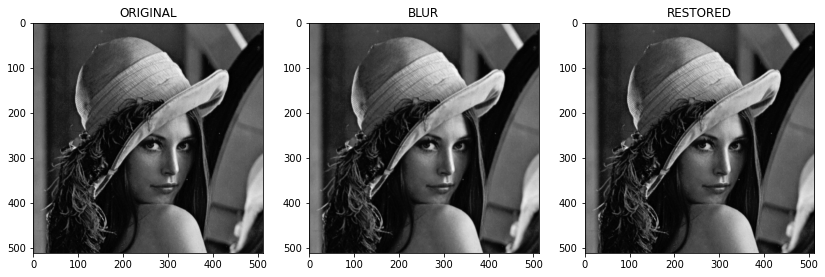

In [153]:
kernel = gaussian_kernel(size=5,sigma=0.5)
kernel = resize_kernel(lena.size,kernel)

img_filtered = apply_filter(lena,kernel)

restored = apply_inverse_filter(img_filtered,kernel)

images = {'ORIGINAL':lena,
          'BLUR':img_filtered,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)

### b - Blur + Noise

MSE: 1149.6300590831013


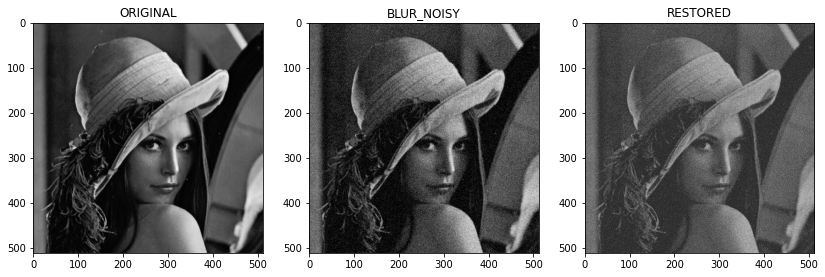

In [154]:
snr = 20
img_filtered_noisy = img_filtered + normal_noise(img_filtered,snr)
img_filtered_noisy = np.clip(img_filtered_noisy, 0, 255)

restored = apply_inverse_filter(img_filtered_noisy,kernel)
images = {'ORIGINAL':lena,
          'BLUR_NOISY':img_filtered_noisy,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)